In [15]:
# Transformers installation
! pip install transformers[torch] datasets evaluate
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.6 MB/s eta 0:00:00


# Fine-tune a pretrained model

There are significant benefits to using a pretrained model. It reduces computation costs, your carbon footprint, and allows you to use state-of-the-art models without having to train one from scratch. 🤗 Transformers provides access to thousands of pretrained models for a wide range of tasks. When you use a pretrained model, you train it on a dataset specific to your task. This is known as fine-tuning, an incredibly powerful training technique.

## Prepare a dataset

Before you can fine-tune a pretrained model, download a dataset and prepare it for training. Here we are going to use the [Spam Text Message Classification dataset](https://www.kaggle.com/datasets/team-ai/spam-text-message-classification).

First, load the dataset.

In [1]:
from datasets import load_dataset

dataset = load_dataset("csv", data_files="../data/spam_text_message.csv")
dataset

DatasetDict({
    train: Dataset({
        features: ['Category', 'Message'],
        num_rows: 5572
    })
})

By default the dataset creates a 'train' split in which all of the rows are present.

Encode the categories with numeric representations. We can use label encoder for this task.

In [2]:
from sklearn.preprocessing import LabelEncoder

In [3]:
encoder = LabelEncoder()

In [4]:
dataset['train']['Category']

['ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'spam',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'spam',
 'ham',
 'ham',
 'spam',
 'spam',
 'h

We will add a new column called 'label' for the encoded categories.

### Important
The ```label``` should always be a column with this name in order for the trainer to recognize it as the target variable.

In [5]:
dataset['train'] = dataset['train'].add_column('label', encoder.fit_transform(dataset['train']['Category']))

In [6]:
dataset['train'] = dataset['train'].remove_columns('Category')

In [7]:
dataset['train']

Dataset({
    features: ['Message', 'label'],
    num_rows: 5572
})

Split the dataset into training, and testing splits: 80%-20%

In [8]:
dataset['train'].train_test_split(test_size=0.2)

DatasetDict({
    train: Dataset({
        features: ['Message', 'label'],
        num_rows: 4457
    })
    test: Dataset({
        features: ['Message', 'label'],
        num_rows: 1115
    })
})

Assign to a variable

In [9]:
dataset = dataset['train'].train_test_split(test_size=0.2)

As you now know, you need a tokenizer to process the text and include a padding and truncation strategy to handle any variable sequence lengths. To process your dataset in one step, use 🤗 Datasets [`map`](https://huggingface.co/docs/datasets/process.html#map) method to apply a preprocessing function over the entire dataset:

In [10]:
def tokenize_function(examples):
    return tokenizer(examples["Message"], padding="max_length", truncation=True)

In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
tokenized_datasets = dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/4457 [00:00<?, ? examples/s]

Map:   0%|          | 0/1115 [00:00<?, ? examples/s]

## Train

## Train with PyTorch Trainer

🤗 Transformers provides a [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) class optimized for training 🤗 Transformers models, making it easier to start training without manually writing your own training loop. The [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) API supports a wide range of training options and features such as logging, gradient accumulation, and mixed precision.

Start by loading your model and specify the number of expected labels. From the dataset we can see that the number is 2 (spam and ham).

In [12]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<Tip>

You will see a warning about some of the pretrained weights not being used and some weights being randomly
initialized. Don't worry, this is completely normal! The pretrained head of the BERT model is discarded, and replaced with a randomly initialized classification head. You will fine-tune this new model head on your sequence classification task, transferring the knowledge of the pretrained model to it.

</Tip>

### Training hyperparameters

Next, create a [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments) class which contains all the hyperparameters you can tune as well as flags for activating different training options. For this tutorial you can start with the default training [hyperparameters](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments), but feel free to experiment with these to find your optimal settings.

Specify where to save the checkpoints from your training and the learning rate:

In [13]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="test_trainer",
    learning_rate=5e-5
)

### Evaluate

[Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) does not automatically evaluate model performance during training. You'll need to pass [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) a function to compute and report metrics. The [🤗 Evaluate](https://huggingface.co/docs/evaluate/index) library provides a simple [`f1`](https://huggingface.co/spaces/evaluate-metric/f1) function you can load with the [evaluate.load](https://huggingface.co/docs/evaluate/main/en/package_reference/loading_methods#evaluate.load) (see this [quicktour](https://huggingface.co/docs/evaluate/a_quick_tour) for more information) function:

In [14]:
import numpy as np
import evaluate

metric = evaluate.load("f1")

Call `compute` on `metric` to calculate the f1 score of your predictions. Before passing your predictions to `compute`, you need to convert the predictions to logits (remember all 🤗 Transformers models return logits):

In [15]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

If you'd like to monitor your evaluation metrics during fine-tuning, specify the `evaluation_strategy` parameter in your training arguments to report the evaluation metric at the end of each epoch:

In [23]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,  # batch size for training
    per_device_eval_batch_size=8,  # batch size for evaluation
    metric_for_best_model="f1",
)

### Trainer

Create a [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) object with your model, training arguments, training and test datasets, and evaluation function:

In [17]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['Message', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4457
    })
    test: Dataset({
        features: ['Message', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1115
    })
})

Pass the model and tokenized datasets to the trainer, along with the trainer arguments.

In [25]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
)

Set the device to GPU if cuda is available. If not, we will fine-tune the model on cpu, which is very slow.

In [19]:
import torch

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Then fine-tune your model by calling [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train):

In [27]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.101300,0.100259,0.945578
2,0.023100,0.086745,0.958333
3,0.008300,0.091230,0.955017


TrainOutput(global_step=1674, training_loss=0.039855496964574286, metrics={'train_runtime': 1362.7988, 'train_samples_per_second': 9.811, 'train_steps_per_second': 1.228, 'total_flos': 3518057921218560.0, 'train_loss': 0.039855496964574286, 'epoch': 3.0})

<a id='pytorch_native'></a>

### Evaluate

In [29]:
trainer.evaluate()

{'eval_loss': 0.09123032540082932,
 'eval_f1': 0.9550173010380623,
 'eval_runtime': 40.1177,
 'eval_samples_per_second': 27.793,
 'eval_steps_per_second': 3.49,
 'epoch': 3.0}

### Predict

In [31]:
predictions = trainer.predict(tokenized_datasets['test'])

In [32]:
predictions

PredictionOutput(predictions=array([[ 5.21901  , -5.291594 ],
       [ 4.2518215, -3.8866682],
       [ 5.236455 , -5.29471  ],
       ...,
       [ 5.2361155, -5.265123 ],
       [ 5.213732 , -5.276478 ],
       [ 5.0914226, -4.9921045]], dtype=float32), label_ids=array([0, 0, 0, ..., 0, 0, 0]), metrics={'test_loss': 0.09123032540082932, 'test_f1': 0.9550173010380623, 'test_runtime': 38.7639, 'test_samples_per_second': 28.764, 'test_steps_per_second': 3.612})

The PredictionOutput object holds the array of predictions per class and the original values of the labels (label_ids)

In order to get the prediction for the class instead of the logits, we need to get the index of the maximum value from the prediction array.

In [34]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

In [35]:
preds

array([0, 0, 0, ..., 0, 0, 0])

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       969
           1       0.97      0.95      0.96       146

    accuracy                           0.99      1115
   macro avg       0.98      0.97      0.97      1115
weighted avg       0.99      0.99      0.99      1115


Text(0.5, 1.0, 'Confusion matrix')

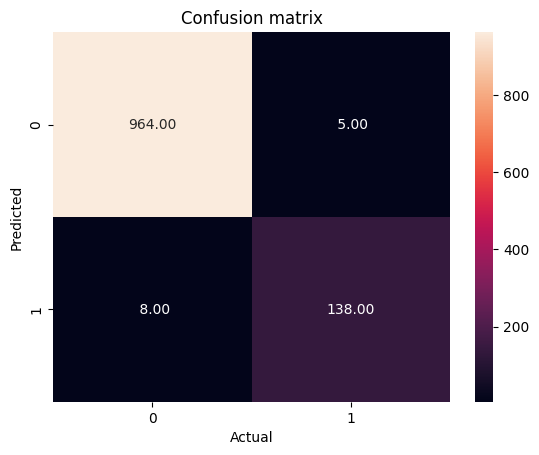

In [44]:
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt='5.2f')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix')